# t-Distributed Stochastic Neighbor Embedding (t-SNE)

Este notebook explora o t-SNE, uma técnica de redução de dimensionalidade não linear particularmente eficaz para a visualização de datasets de alta dimensão. Diferentemente de métodos como o PCA, que se concentram em preservar a variância global, o t-SNE foca em preservar a estrutura local, ou seja, as similaridades entre pontos vizinhos. Ele modela as similaridades entre pontos de dados tanto no espaço de alta dimensão quanto no de baixa dimensão e busca minimizar a divergência entre essas duas distribuições de similaridade.

## Fundamentação

O t-SNE opera em duas etapas principais: primeiro, ele constrói uma distribuição de probabilidade sobre pares de pontos de dados de alta dimensão, de modo que pontos similares tenham uma alta probabilidade de serem escolhidos, enquanto pontos dissimilares tenham uma probabilidade extremamente baixa. Segundo, ele define uma distribuição de probabilidade similar sobre os pontos no mapa de baixa dimensão e minimiza a divergência de Kullback-Leibler (KL) entre as duas distribuições em relação às localizações dos pontos no mapa.

### Similaridades no Espaço de Alta Dimensão

A similaridade entre os pontos de dados $x_i$ e $x_j$ é a probabilidade condicional, $p_{j|i}$, de que $x_i$ escolheria $x_j$ como seu vizinho se os vizinhos fossem escolhidos em proporção à sua densidade de probabilidade sob uma Gaussiana centrada em $x_i$. A probabilidade é dada por:

$$
p_{j|i} = \frac{\exp(-\|x_i - x_j\|^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\|x_i - x_k\|^2 / 2\sigma_i^2)}
$$

A variância da Gaussiana, $\sigma_i^2$, é determinada para cada ponto de dados individualmente através de uma busca binária. Essa busca é realizada para encontrar um $\sigma_i$ que produza uma distribuição de probabilidade $P_i$ com uma perplexidade específica, um hiperparâmetro definido pelo usuário. A perplexidade pode ser interpretada como uma medida suave do número efetivo de vizinhos para cada ponto.

Para obter uma distribuição de probabilidade conjunta, o t-SNE simetriza essas probabilidades condicionais:

$$
p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n}
$$

onde $n$ é o número de pontos de dados.

### Similaridades no Espaço de Baixa Dimensão

No espaço de baixa dimensão (geralmente 2D ou 3D), o t-SNE utiliza uma distribuição t de Student com um grau de liberdade (que é equivalente a uma distribuição de Cauchy) para medir as similaridades entre os pontos de baixa dimensão $y_i$ e $y_j$. O uso de uma distribuição de cauda longa como a t de Student permite que pontos moderadamente distantes no espaço de alta dimensão sejam mapeados para distâncias maiores no espaço de baixa dimensão, ajudando a aliviar o problema de "crowding" (aglomeração). A probabilidade conjunta $q_{ij}$ é definida como:

$$
q_{ij} = \frac{(1 + \|y_i - y_j\|^2)^{-1}}{\sum_{k \neq l} (1 + \|y_k - y_l\|^2)^{-1}}
$$

### Otimização via Minimização da Divergência KL

O objetivo do t-SNE é fazer com que a distribuição $Q$ (no espaço de baixa dimensão) reflita a distribuição $P$ (no espaço de alta dimensão) da melhor forma possível. Isso é alcançado minimizando a divergência de Kullback-Leibler entre as duas distribuições:

$$
C = \text{KL}(P||Q) = \sum_{i} \sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}}
$$

A minimização desta função de custo é realizada usando o método do gradiente descendente. O gradiente da divergência KL em relação aos pontos no embedding $y_i$ possui uma forma surpreendentemente simples, que é a diferença entre as forças de atração (puxando pontos similares para perto) e as forças de repulsão (empurrando pontos dissimilares para longe).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns

### Gerando um Dataset Sintético

Para demonstrar o t-SNE, vamos primeiro gerar um conjunto de dados sintético com clusters bem definidos. Usaremos a função `make_blobs` da biblioteca `scikit-learn`.

In [2]:
n_samples = 300
n_features = 20
n_clusters = 5

X, y = make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=n_clusters,
    random_state=42,
    cluster_std=5.0
)

print("Formato do dataset X:", X.shape)
print("Formato do vetor y:", y.shape)

Formato do dataset X: (300, 20)
Formato do vetor y: (300,)


In [ ]:
df = pd.DataFrame(X[:, :8], columns=[f'feature_{i+1}' for i in range(8)])
df['cluster'] = y

sns.pairplot(df, hue='cluster', palette='hls')
plt.suptitle("Pairplot das primeiras features (sem t-SNE)", y=1.02)
plt.show()

## Implementação da Classe t-SNE

Agora, vamos implementar o algoritmo t-SNE, encapsulando a lógica em uma classe Python com uma interface similar à do `scikit-learn`. Esta implementação se concentrará na clareza do algoritmo, em vez de otimizações de performance.

In [3]:
class TSNE:
    def __init__(self, n_components=2, perplexity=30.0, lr=200.0, n_iter=500):
        # Número de dimensões finais, perplexidade, taxa de aprendizado e iterações
        self.n_components = n_components
        self.perplexity = perplexity
        self.lr = lr
        self.n_iter = n_iter

    # -------------------------------------------------------
    # 1. Calcula matriz de distâncias euclidianas ao quadrado
    # -------------------------------------------------------
    def _distances(self, X):
        sum_X = np.sum(X**2, axis=1)
        return np.add(np.add(-2 * X @ X.T, sum_X).T, sum_X)

    # -------------------------------------------------------------------------
    # 2. Calcula a matriz P (probabilidades no espaço de alta dimensão)
    #    Cada linha P[i] é ajustada para ter uma entropia que corresponda à perplexidade
    # -------------------------------------------------------------------------
    def _p_matrix(self, D):
        n = D.shape[0]
        P = np.zeros((n, n))
        logU = np.log2(self.perplexity)

        for i in range(n):
            beta = 1.0  # inverso da variância (1 / (2*sigma²))
            Di = np.delete(D[i], i)  # remove a distância com ele mesmo

            # Ajuste de beta por busca simples até alcançar a perplexidade desejada
            for _ in range(30):
                P_i = np.exp(-Di * beta)
                P_i /= np.sum(P_i)
                H = -np.sum(P_i * np.log2(P_i + 1e-12))  # entropia
                if abs(H - logU) < 1e-3:  # se já está próximo, para
                    break
                beta *= 1.2 if H > logU else 0.8  # ajusta beta

            P[i, np.arange(n) != i] = P_i

        # Simetriza e normaliza
        P = (P + P.T) / (2 * n)
        return np.maximum(P, 1e-12)

    # -------------------------------------------------------
    # 3. Executa o t-SNE e retorna o embedding 2D
    # -------------------------------------------------------
    def fit_transform(self, X):
        n = X.shape[0]

        # Calcula afinidades no espaço original (P)
        D = self._distances(X)
        P = self._p_matrix(D)

        # Inicializa o embedding aleatoriamente
        Y = np.random.randn(n, self.n_components)

        # Loop de otimização
        for it in range(self.n_iter):
            # Calcula afinidades no espaço de baixa dimensão (Q)
            sum_Y = np.sum(Y**2, axis=1)
            num = 1 / (1 + np.add(np.add(-2 * Y @ Y.T, sum_Y).T, sum_Y))
            np.fill_diagonal(num, 0)
            Q = np.maximum(num / np.sum(num), 1e-12)

            # Calcula o gradiente
            PQ = P - Q
            for i in range(n):
                # Soma ponderada das diferenças (força de atração/repulsão)
                dY_i = np.sum((PQ[:, i] * num[:, i])[:, None] * (Y[i] - Y), axis=0)
                Y[i] -= self.lr * dY_i  # Atualiza posição

            # Centraliza os pontos
            Y -= np.mean(Y, axis=0)

            # Mostra custo a cada 100 iterações
            if (it + 1) % 100 == 0:
                cost = np.sum(P * np.log(P / Q))
                print(f"Iter {it+1:4d}: cost = {cost:.4f}")

        return Y

### Aplicando

Vamos agora instanciar nossa classe `TSNE` e aplicá-la ao mesmo dataset sintético. O processo de otimização será impresso, mostrando o valor da função de custo em intervalos regulares.

In [ ]:
custom_tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, lr=200)
X_embedded_custom = custom_tsne.fit_transform(X)

### Visualizando o Resultado da Implementação

Finalmente, plotamos o resultado gerado pela nossa implementação.

In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_embedded_custom[:, 0],
    y=X_embedded_custom[:, 1],
    hue=y,
    palette=sns.color_palette("hls", n_clusters),
    legend="full"
)
plt.title('Visualização t-SNE com Implementação Customizada')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.grid(True)
plt.show()

## Exercícios

### Exercício 1

Treine diferentes modelos t-SNE em 2D com diferentes valores de perplexidade para o dataset sintético e plote cada um deles.

### Exercício 2

Faça um treinamento de um modelo t-SNE para o Dataset Wine. Em seguida, plote o resultado em duas dimensões.

### Solução Exercício 1: Diferentes Valores de Perplexidade

Vamos treinar modelos t-SNE com diferentes valores de perplexidade para visualizar como esse hiperparâmetro afeta a estrutura dos clusters no espaço de baixa dimensão.


Treinando t-SNE com perplexidade = 5


/tmp/ipykernel_17450/26374851.py:32: RuntimeWarning: invalid value encountered in divide
  P_i /= np.sum(P_i)


Iter  100: cost = 1.9914
Iter  200: cost = 1.6932
Iter  200: cost = 1.6932
Iter  300: cost = 1.5680
Iter  300: cost = 1.5680
Iter  400: cost = 1.4907
Iter  400: cost = 1.4907
Iter  500: cost = 1.4344
Iter  500: cost = 1.4344
Iter  600: cost = 1.3940
Iter  600: cost = 1.3940
Iter  700: cost = 1.3620
Iter  700: cost = 1.3620
Iter  800: cost = 1.3362
Iter  800: cost = 1.3362
Iter  900: cost = 1.3147
Iter  900: cost = 1.3147
Iter 1000: cost = 1.2955

Treinando t-SNE com perplexidade = 15
Iter 1000: cost = 1.2955

Treinando t-SNE com perplexidade = 15
Iter  100: cost = 1.2122
Iter  100: cost = 1.2122
Iter  200: cost = 1.0518
Iter  200: cost = 1.0518
Iter  300: cost = 0.9908
Iter  300: cost = 0.9908
Iter  400: cost = 0.9528
Iter  400: cost = 0.9528
Iter  500: cost = 0.9197
Iter  500: cost = 0.9197
Iter  600: cost = 0.8978
Iter  600: cost = 0.8978
Iter  700: cost = 0.8827
Iter  700: cost = 0.8827
Iter  800: cost = 0.8707
Iter  800: cost = 0.8707
Iter  900: cost = 0.8608
Iter  900: cost = 0.86

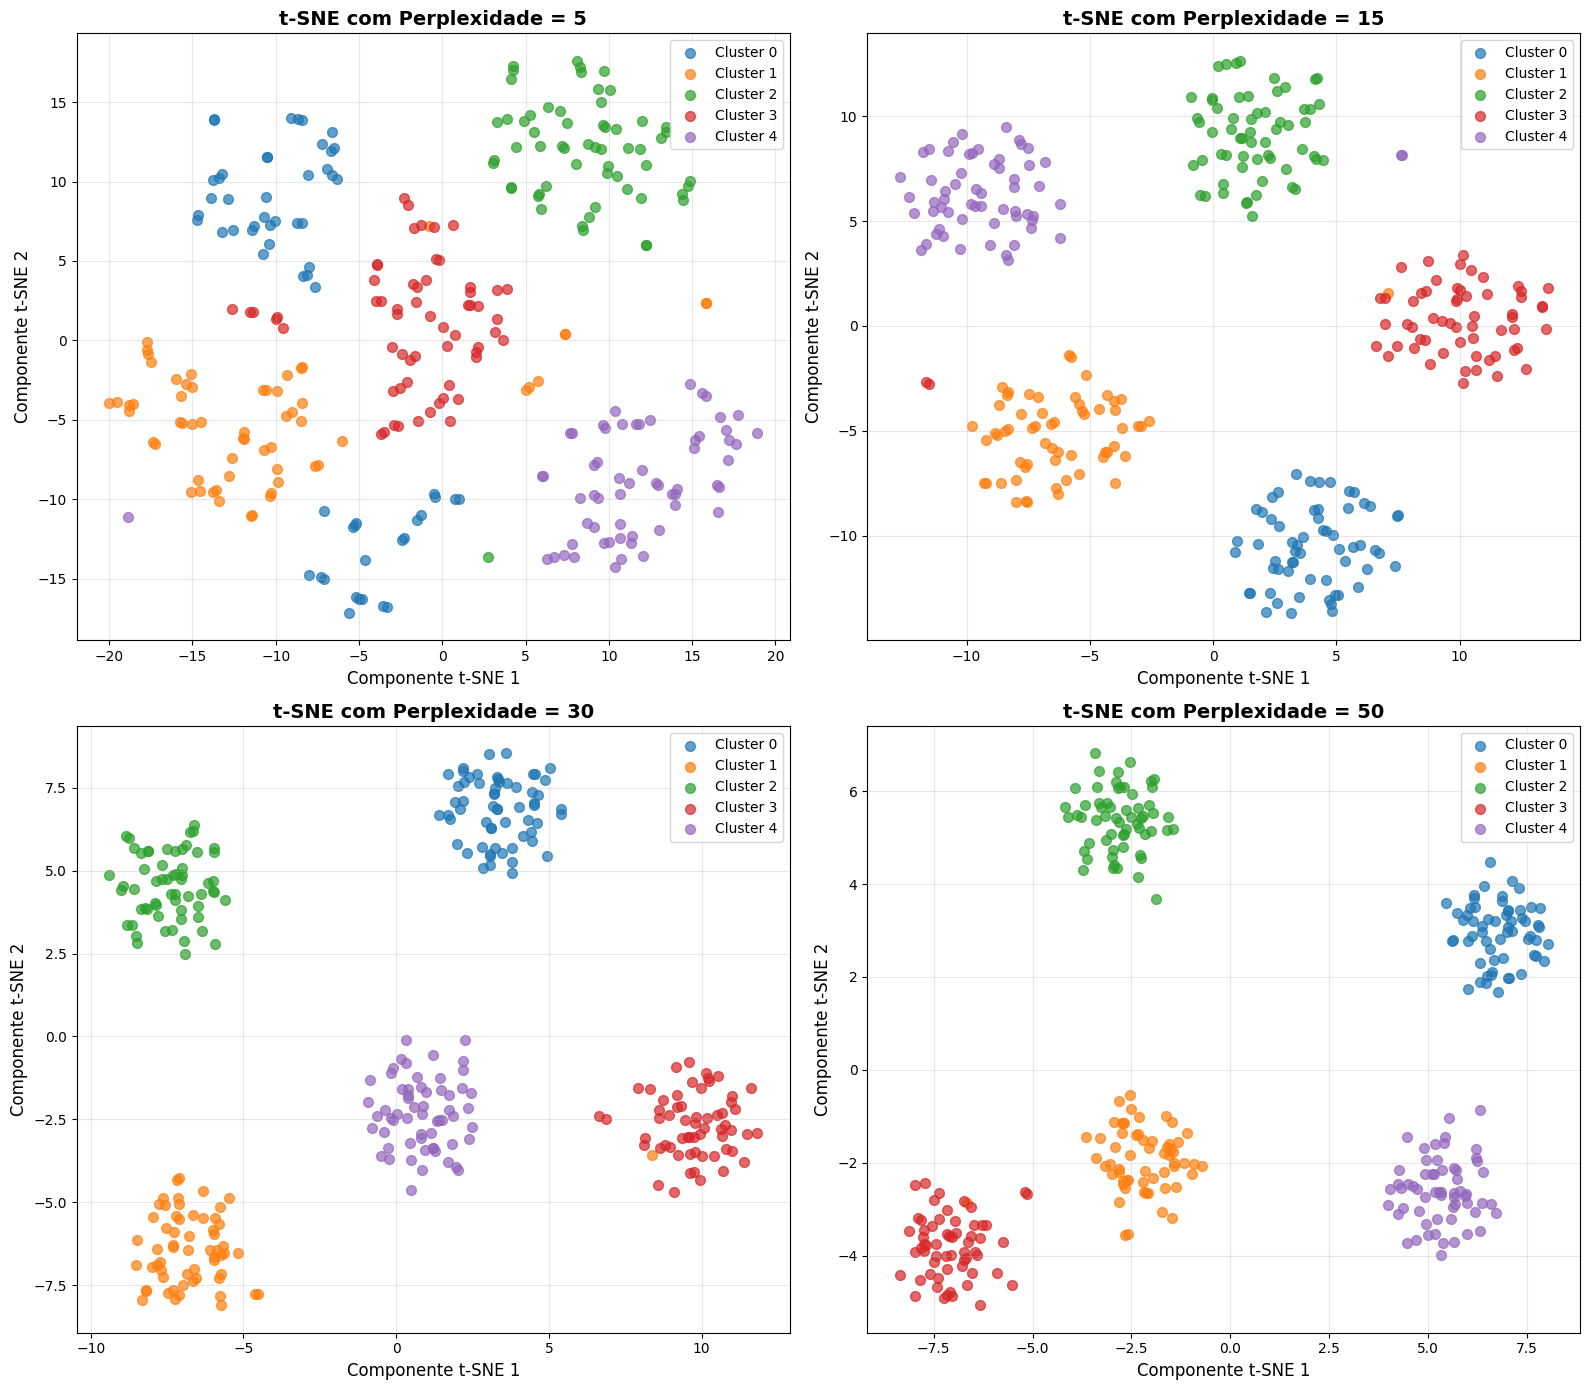

In [4]:
# Testar diferentes valores de perplexidade
perplexities = [5, 15, 30, 50]

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, perp in enumerate(perplexities):
    print(f"\n{'='*50}")
    print(f"Treinando t-SNE com perplexidade = {perp}")
    print(f"{'='*50}")
    
    # Treinar t-SNE customizado
    tsne_model = TSNE(n_components=2, perplexity=perp, n_iter=1000, lr=200)
    X_embedded = tsne_model.fit_transform(X)
    
    # Plotar
    ax = axes[idx]
    for i in range(n_clusters):
        mask = y == i
        ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], 
                  label=f'Cluster {i}', alpha=0.7, s=50)
    
    ax.set_title(f't-SNE com Perplexidade = {perp}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Componente t-SNE 1', fontsize=12)
    ax.set_ylabel('Componente t-SNE 2', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Análise dos Resultados:**

A perplexidade é um hiperparâmetro crucial no t-SNE que afeta a forma como o algoritmo equilibra a atenção entre estruturas locais e globais:

- **Perplexidade baixa (5)**: Foca muito em estruturas locais, podendo criar muitos pequenos clusters e fragmentar grupos que deveriam estar juntos.
- **Perplexidade moderada (15-30)**: Geralmente oferece um bom equilíbrio, revelando a estrutura natural dos dados.
- **Perplexidade alta (50)**: Pode suavizar demais os clusters, fundindo grupos que deveriam estar separados.

O valor ideal de perplexidade tipicamente está entre 5 e 50, sendo 30 um valor padrão razoável para começar.

### Solução Exercício 2: Dataset Wine com t-SNE

Vamos aplicar o t-SNE ao dataset Wine para visualizar as três classes de vinho em um espaço bidimensional.

In [5]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

# Carregar o dataset Wine
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dimensões do Wine dataset:", X_wine.shape)
print("Número de classes:", len(wine.target_names))
print("Classes:", wine.target_names)

Dimensões do Wine dataset: (178, 13)
Número de classes: 3
Classes: ['class_0' 'class_1' 'class_2']


In [6]:
# Padronizar os dados (importante para t-SNE)
scaler = StandardScaler()
X_wine_scaled = scaler.fit_transform(X_wine)

print("Dados padronizados com sucesso!")
print("Média após padronização:", np.mean(X_wine_scaled, axis=0).round(10))
print("Desvio padrão após padronização:", np.std(X_wine_scaled, axis=0).round(2))

Dados padronizados com sucesso!
Média após padronização: [ 0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.  0. -0.]
Desvio padrão após padronização: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [7]:
# Treinar t-SNE no dataset Wine
print("\nTreinando t-SNE no Wine dataset...")
print("="*50)

tsne_wine = TSNE(n_components=2, perplexity=30.0, n_iter=1000, lr=200)
X_wine_embedded = tsne_wine.fit_transform(X_wine_scaled)


Treinando t-SNE no Wine dataset...
Iter  100: cost = 0.4942
Iter  200: cost = 0.4320
Iter  100: cost = 0.4942
Iter  200: cost = 0.4320
Iter  300: cost = 0.4071
Iter  300: cost = 0.4071
Iter  400: cost = 0.3904
Iter  400: cost = 0.3904
Iter  500: cost = 0.3843
Iter  500: cost = 0.3843
Iter  600: cost = 0.3805
Iter  600: cost = 0.3805
Iter  700: cost = 0.3779
Iter  700: cost = 0.3779
Iter  800: cost = 0.3759
Iter  800: cost = 0.3759
Iter  900: cost = 0.3744
Iter  900: cost = 0.3744
Iter 1000: cost = 0.3732
Iter 1000: cost = 0.3732


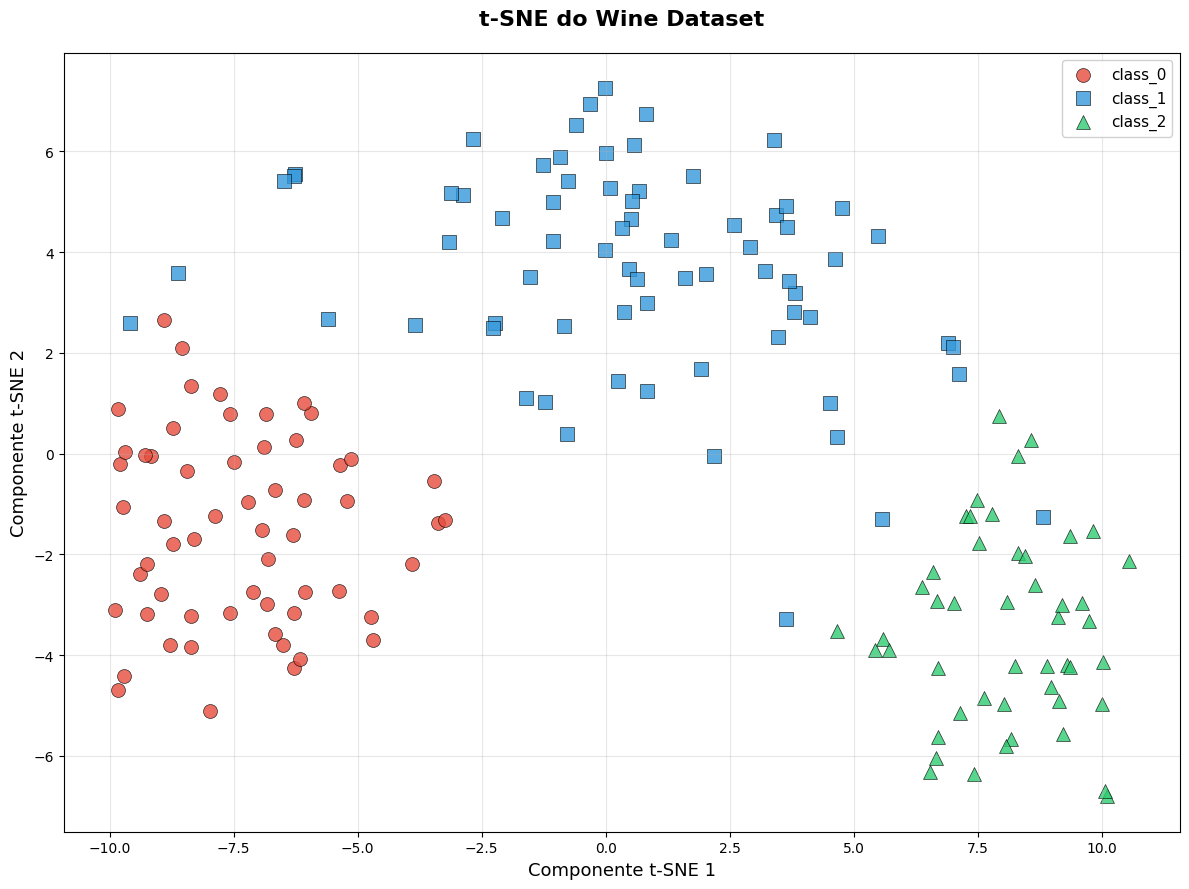

In [8]:
# Visualizar o resultado
plt.figure(figsize=(12, 9))

colors = ['#e74c3c', '#3498db', '#2ecc71']
markers = ['o', 's', '^']

for i, (color, marker, target_name) in enumerate(zip(colors, markers, wine.target_names)):
    mask = y_wine == i
    plt.scatter(X_wine_embedded[mask, 0], 
               X_wine_embedded[mask, 1],
               c=color, 
               marker=marker,
               s=100,
               alpha=0.8,
               edgecolors='black',
               linewidth=0.5,
               label=target_name)

plt.title('t-SNE do Wine Dataset', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Componente t-SNE 1', fontsize=13)
plt.ylabel('Componente t-SNE 2', fontsize=13)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Análise do Resultado:**

O t-SNE conseguiu visualizar efetivamente as três classes de vinho no espaço bidimensional:

1. **Separação de Classes**: As três classes de vinho (class_0, class_1 e class_2) aparecem como clusters distintos no espaço t-SNE, demonstrando que os vinhos de diferentes cultivares têm características químicas suficientemente diferentes.

2. **Preservação da Estrutura Local**: O t-SNE preservou a similaridade local entre amostras da mesma classe, agrupando-as próximas umas das outras.

3. **Comparação com PCA**: Enquanto o PCA busca preservar a variância global, o t-SNE foca em preservar a estrutura de vizinhança local, frequentemente resultando em visualizações mais claras de clusters, especialmente quando as classes têm relações não-lineares no espaço original.

4. **Interpretação**: A visualização mostra que cada cultivar de vinho tem uma "assinatura química" distinta que pode ser capturada em apenas 2 dimensões através do t-SNE.

### Comparação: t-SNE vs PCA no Wine Dataset

Para ilustrar melhor as diferenças entre t-SNE e PCA, vamos compará-los lado a lado.

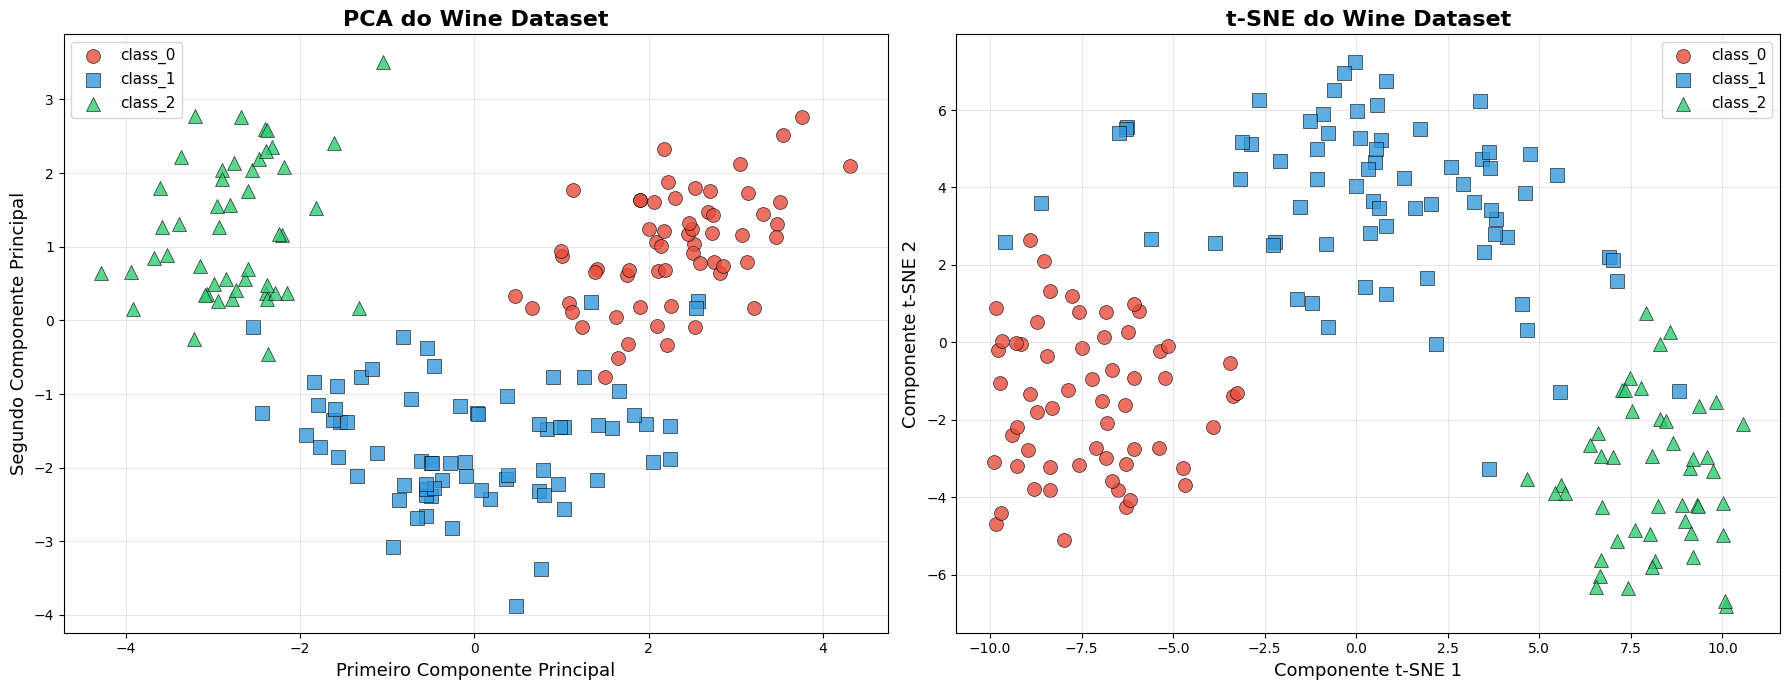


Variância explicada pelo PCA:
PC1: 36.20%
PC2: 19.21%
Total: 55.41%


In [9]:
from sklearn.decomposition import PCA

# Aplicar PCA
pca = PCA(n_components=2)
X_wine_pca = pca.fit_transform(X_wine_scaled)

# Criar visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot PCA
ax1 = axes[0]
for i, (color, marker, target_name) in enumerate(zip(colors, markers, wine.target_names)):
    mask = y_wine == i
    ax1.scatter(X_wine_pca[mask, 0], 
               X_wine_pca[mask, 1],
               c=color, 
               marker=marker,
               s=100,
               alpha=0.8,
               edgecolors='black',
               linewidth=0.5,
               label=target_name)

ax1.set_title('PCA do Wine Dataset', fontsize=16, fontweight='bold')
ax1.set_xlabel('Primeiro Componente Principal', fontsize=13)
ax1.set_ylabel('Segundo Componente Principal', fontsize=13)
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot t-SNE
ax2 = axes[1]
for i, (color, marker, target_name) in enumerate(zip(colors, markers, wine.target_names)):
    mask = y_wine == i
    ax2.scatter(X_wine_embedded[mask, 0], 
               X_wine_embedded[mask, 1],
               c=color, 
               marker=marker,
               s=100,
               alpha=0.8,
               edgecolors='black',
               linewidth=0.5,
               label=target_name)

ax2.set_title('t-SNE do Wine Dataset', fontsize=16, fontweight='bold')
ax2.set_xlabel('Componente t-SNE 1', fontsize=13)
ax2.set_ylabel('Componente t-SNE 2', fontsize=13)
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVariância explicada pelo PCA:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca.explained_variance_ratio_):.2%}")